In [298]:
import MDAnalysis
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import mdtraj as md
import itertools
import copy
import pickle
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [33]:
dyes = {}
dyes['A48_C1R'] = {'indices': [[85,52,56,59],[52,56,59,60],[56,59,60,66],[66,65,68,71],
                        [65,68,71,74],[68,71,74,77],[71,74,77,80],[74,77,80,83],[77,80,83,40]], 
                   'peaks': []}
dyes['A59_C1R'] = {'indices': [[120,87,91,94],[87,91,94,95],[91,94,95,101],[101,100,103,106],
                                [100,103,106,109],[103,106,109,112],[106,109,112,115],
                                [109,112,115,118],[112,115,118,39]],
                   'peaks': []}

In [34]:
df = pd.DataFrame(dyes).T

In [35]:
def calcDihe(df, dye):
    t = md.load_xtc(dye+'/traj.xtc',dye+'/conf_ed.gro')
    dihe = md.compute_dihedrals(t, df.loc[dye,'indices'], periodic=True, opt=True)/np.pi*180
    np.savetxt('dihedrals/'+dye+'.txt',dihe)

In [36]:
for dye in df.index:
    calcDihe(df, dye)

In [37]:
def genPeaks(df, dye):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    peaks = []
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
    for i,ax in enumerate(axes.flatten()):
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 1),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        p, properties = find_peaks(h, prominence=.0005, width=2, distance=60)
        ax.plot(bins,h)
        if h.argmax() not in p:
            p = np.append(p,h.argmax())
        print(p,bins[p])
        ax.vlines(bins[p],ymin=0,ymax=h.max())
        peaks.append(bins[p])
    for i in [0,3,6,2,5,8]:
        axes.flatten()[i].set_ylabel(r'$P(\theta)$')
    for i in [6,7,8]:
        axes.flatten()[i].set_xlabel(r'$\theta$ / deg')
    for i in [2,5,8]:
        axes.flatten()[i].yaxis.set_ticks_position('right')
        axes.flatten()[i].yaxis.set_label_position("right")
    fig.suptitle(dye)
    plt.show()
    df.loc[dye,'peaks'] = np.array(peaks)

[ 18 119 242] [-161.5  -60.5   62.5]
[120 269 354] [-59.5  89.5 174.5]
[104 228   1] [ -75.5   48.5 -178.5]
[ 85 273] [-94.5  93.5]
[  1 114 246] [-178.5  -65.5   66.5]
[106 248 356] [-73.5  68.5 176.5]
[110 244 358] [-69.5  64.5 178.5]
[117 241 358] [-62.5  61.5 178.5]
[ 80 278   0] [ -99.5   98.5 -179.5]


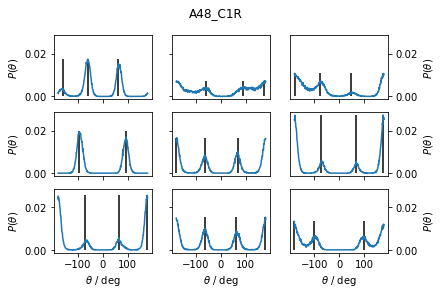

[ 11 122 247] [-168.5  -57.5   67.5]
[110 270   1] [ -69.5   90.5 -178.5]
[138 251 355] [-41.5  71.5 175.5]
[ 88 269] [-91.5  89.5]
[108 249 359] [-71.5  69.5 179.5]
[110 247 359] [-69.5  67.5 179.5]
[111 246 359] [-68.5  66.5 179.5]
[112 245   0] [ -67.5   65.5 -179.5]
[ 82 273 358] [-97.5  93.5 178.5]


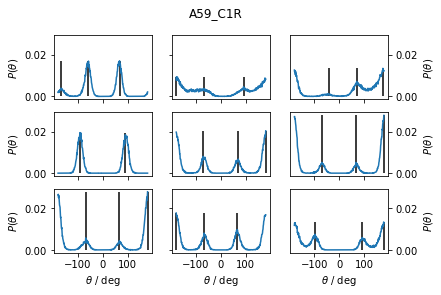

In [38]:
for dye in df.index:
    genPeaks(df, dye)

In [91]:
def genClusters(df, dye, path):
    dihedrals = np.loadtxt('dihedrals/'+dye+'.txt')
    peaks = np.array(list(itertools.product(*df.loc[dye,'peaks'])))
    print(peaks.shape,'peaks combinations')
    cluster_dict = {}
    final_cluster_dict = {}
    for frame_index, frame_dihe in enumerate(dihedrals):
        sqdist = (frame_dihe - peaks) ** 2
        #print(sqdist.shape,'shape sqdist')
        
        sqdist1 = ((frame_dihe + 360) - peaks) ** 2
        sqdist2 = ((frame_dihe - 360) - peaks) ** 2
        indices1 = sqdist1 < sqdist
        indices2 = sqdist2 < sqdist
        if np.sum(indices1)>0:
            sqdist[indices1] = sqdist1[indices1]
        if np.sum(indices2)>0:
            sqdist[indices2] = sqdist2[indices2]
        
        sumleastsq = np.sum(sqdist, axis=1)
        #print(sumleastsq.shape,'shape sumleastsq')
        min_index = np.argmin(sumleastsq) # index of peaks combination that is closer to frame
        if min_index not in cluster_dict.keys():
            cluster_dict[min_index] = [frame_dihe]
        else:
            cluster_dict[min_index].append(frame_dihe)
    new_peaks = np.zeros((len(cluster_dict.keys()),9))
    for index, value in enumerate(cluster_dict.keys()):
        #print(np.array(cluster_dict[value]).shape,'shape cluster_dict[value]')
        new_peaks[index] = np.mean(cluster_dict[value], axis=0)
    #df.loc[dye]['new_peaks'] = new_peaks
    #new_peaks = np.array(df.loc[dye,'new_peaks'])
    print(np.zeros((len(cluster_dict.keys()),9)).shape, new_peaks.shape)
    for frame_index, frame_dihe in enumerate(dihedrals):
        sqdist = (frame_dihe - new_peaks) ** 2
        
        sqdist1 = ((frame_dihe + 360) - new_peaks) ** 2
        sqdist2 = ((frame_dihe - 360) - new_peaks) ** 2
        indices1 = sqdist1 < sqdist
        indices2 = sqdist2 < sqdist
        if np.sum(indices1)>0:
            sqdist[indices1] = sqdist1[indices1]
        if np.sum(indices2)>0:
            sqdist[indices2] = sqdist2[indices2]
        
        sumleastsq = np.sum(sqdist, axis=1)
        min_index = np.argmin(sumleastsq)
        min_value = sumleastsq[min_index]
        if min_index not in final_cluster_dict.keys():
            final_cluster_dict[min_index] = {'frame': frame_index, 'min': min_value, 
                                             'dihe': new_peaks[min_index], 'N': 1}
        else:
            if min_value < final_cluster_dict[min_index]['min']:
                final_cluster_dict[min_index]['frame'] = frame_index
                final_cluster_dict[min_index]['min'] = min_value
                final_cluster_dict[min_index]['dihe'] = new_peaks[min_index]
                final_cluster_dict[min_index]['N'] += 1
            else:
                final_cluster_dict[min_index]['N'] += 1
    pd.DataFrame(final_cluster_dict).T.to_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    #np.savetxt(path+'/{:s}_avg_peaks.dat'.format(dye),new_peaks)

In [92]:
def filterCluster(df, dye, path, cutoff):
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))

    discarded_frames = clusters[clusters.N < cutoff].frame.values.astype(int)
    discarded_peaks = clusters[clusters.N < cutoff].index
    frequency = clusters[clusters.N < cutoff].N.values
    print('Initial clusters',len(clusters.index)) 
            
    clusters.drop(discarded_peaks, inplace=True)
    print('Final clusters',len(clusters.index)) 

    dihedrals = np.loadtxt('dihedrals/'+dye+'.txt')
    sel_dihe = np.array(clusters.dihe.tolist())
    
    for frame_index, frame_dihe in enumerate(dihedrals[discarded_frames]):
        sqdist = (frame_dihe - sel_dihe) ** 2
        sqdist1 = ((frame_dihe + 360) - sel_dihe) ** 2
        sqdist2 = ((frame_dihe - 360) - sel_dihe) ** 2
        indices1 = sqdist1 < sqdist
        indices2 = sqdist2 < sqdist
        if np.sum(indices1)>0:
            sqdist[indices1] = sqdist1[indices1]
        if np.sum(indices2)>0:
            sqdist[indices2] = sqdist2[indices2]
        sumleastsq = np.sum(sqdist, axis=1)
        clusters.iloc[sumleastsq.argmin()]['N'] += frequency[frame_index]
    clusters.to_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))

In [110]:
def genRotLib(df, dye, path, cutoff):
    clusters = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))

    print(clusters.N.sum())
    u = MDAnalysis.Universe(dye+'/conf_ed.gro', dye+'/traj.xtc')
    alexa = u.select_atoms('all and not (resname ACE or resname NHE)')
    alexa.write('{:s}/rot_lib_matrix_{:s}.pdb'.format(path,dye))
    Ca_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name CA')
    N_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name N')
    C_pos = u.select_atoms('all and not (resname ACE or resname NHE) and name C')
    new_coords = np.empty(0)
    for ts in u.trajectory[clusters.frame.values]:
        offset = Ca_pos.positions.copy()
        Ca_cords = Ca_pos.positions - offset
        N_cords = N_pos.positions - offset
        C_cords = C_pos.positions - offset
        alexa_coords = alexa.positions - offset
        x_vector = N_cords - Ca_cords
        x_vector /= np.linalg.norm(x_vector)
        yt_vector = C_cords - Ca_cords
        yt_vector /= np.linalg.norm(yt_vector)
        z_vector = np.cross(x_vector, yt_vector)
        z_vector /= np.linalg.norm(z_vector)
        y_vector = np.cross(z_vector, x_vector)
        rotation = np.array((x_vector, y_vector, z_vector)).T
        alexa_coords = np.dot(alexa_coords, rotation.reshape(3,3))
        alexa_coords = alexa_coords.reshape((len(alexa_coords), 3))
        new_coords = np.append(new_coords, alexa_coords)
    new_coords = new_coords.reshape((len(clusters.frame.values), len(alexa), 3))
    output_file = open(path+'/rot_lib_matrix_{:s}_{:d}.txt'.format(dye,cutoff), 'w')
    for index, conformer in enumerate(new_coords):
        for atom_index, atom in enumerate(conformer):
            output_file.write('{0:>3} {1:>3} {2[0]:> 10.6f} {2[1]:> 10.6f} {2[2]:> 10.6f} {3:>5}\n'.format(index+1, 
                            alexa[atom_index].id-alexa[1].id, atom, clusters.N.values[index]))
    output_file.close()

In [254]:
def plotClustHist(df, dye, cutoff):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters_cutoff = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))
    print(clusters_cutoff.dihe.shape)
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)
    for i,ax in enumerate(axes.flatten()):
        
        #h, b = np.histogram(np.array(clusters.dihe.tolist())[:,i],bins=np.arange(-180, 181, 2),density=True)
        #bins = b[:-1]+(b[1]-b[0])/2
        #ax.plot(bins,h,color=plt.cm.tab10(2),lw=0.5)
        
        h, b = np.histogram(np.array(clusters_cutoff.dihe.tolist())[:,i],
                            bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        ax.plot(bins,h,color=plt.cm.tab10(3),lw=0.5,ls=':')
        
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        
        ax.vlines(df.loc[dye,'peaks'][i],ymin=0,ymax=1,color='k')
        ax.plot(bins,h,lw=2)
        
        ax.set_ylim(0,h.max()+0.01)
        
    for i in [0,3,6,2,5,8]:
        axes.flatten()[i].set_ylabel(r'$P(\theta)$')
    for i in [6,7,8]:
        axes.flatten()[i].set_xlabel(r'$\theta$ / deg')
    for i in [2,5,8]:
        axes.flatten()[i].yaxis.set_ticks_position('right')
        axes.flatten()[i].yaxis.set_label_position("right")
    Nrotamers = len(clusters_cutoff.index)
    fig.suptitle(dye.replace('_',' ')+' cutoff {:d}, {:d} rotamers'.format(cutoff, Nrotamers))
    plt.savefig(path+'/hist_{:s}_{:d}.pdf'.format(dye,cutoff))
    plt.show()

In [255]:
def plotClustPolar(df, dye, cutoff):
    dihe = np.loadtxt('dihedrals/'+dye+'.txt')
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters_cutoff = pd.read_pickle(path+'/clusters_{:s}_{:d}_cutoff.pkl'.format(dye,cutoff))
    print(clusters_cutoff.dihe.shape)
    fig, axes = plt.subplots(3, 3, sharex=False, sharey=False, subplot_kw=dict(polar=True), 
                             figsize=(7,6))
    for i,ax in enumerate(axes.flatten()):
        h, b = np.histogram(dihe[:,i],bins=np.arange(-180, 181, 2),density=True)
        bins = b[:-1]+(b[1]-b[0])/2
        
        ax.vlines((df.loc[dye,'peaks'][i]+180)/180*np.pi,ymin=0,ymax=h.max(),color='k')
        #ax.vlines((np.array(clusters.dihe.tolist())[:,i]+180)/180*np.pi,
        #          ymin=0,ymax=h.max(),color=plt.cm.tab10(2),lw=0.5)
        ax.vlines((np.array(clusters_cutoff.dihe.tolist())[:,i]+180)/180*np.pi,
                  ymin=0,ymax=h.max(),color=plt.cm.tab10(3),lw=0.5,ls=':')
        
        ax.plot((bins+180)/180*np.pi,h,lw=2)
        
        ax.set_xticks([0,np.pi/2,np.pi,3/2*np.pi])
        ax.set_yticks([])
        ax.grid(False)
        
    plt.tight_layout(h_pad=1)
    Nrotamers = len(clusters_cutoff.index)
    fig.suptitle(dye.replace('_',' ')+' cutoff {:d}, {:d} rotamers'.format(cutoff, Nrotamers),y=1.015)
    plt.savefig(path+'/{:s}_{:d}.pdf'.format(dye,cutoff))
    plt.show()

In [ ]:
%%time
path='genLIB2'
for dye in df.index:
    genClusters(df, dye, path)
    for cutoff in [75,150,200]:
        filterCluster(df, dye, path, cutoff)
        genRotLib(df, dye, path, cutoff)

(143,)


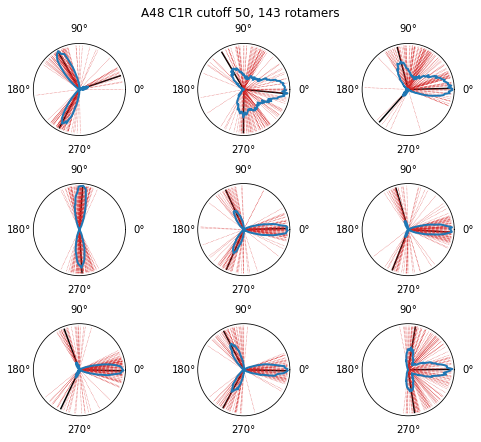

(78,)


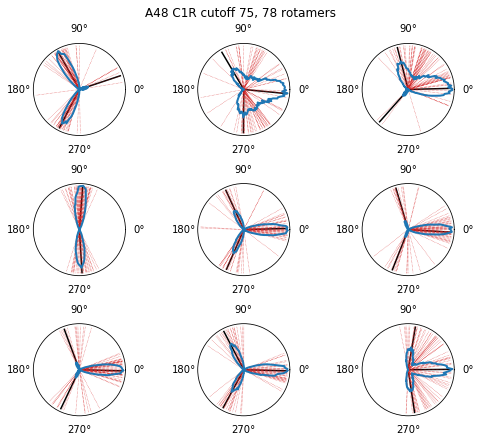

(35,)


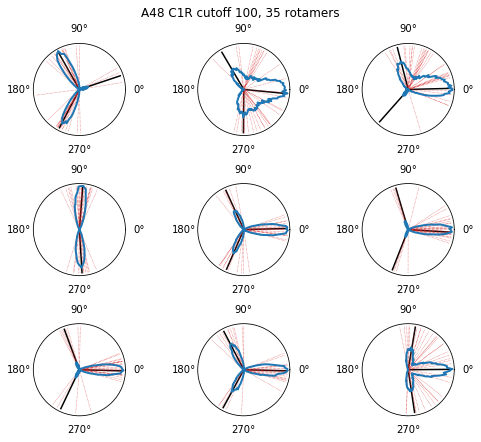

(16,)


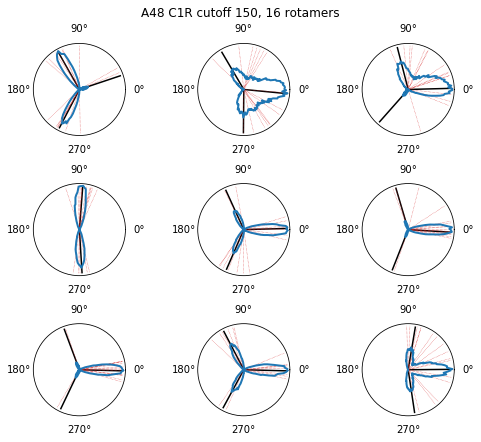

(4,)


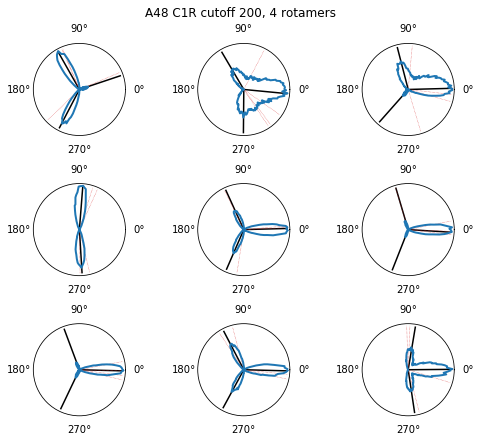

(136,)


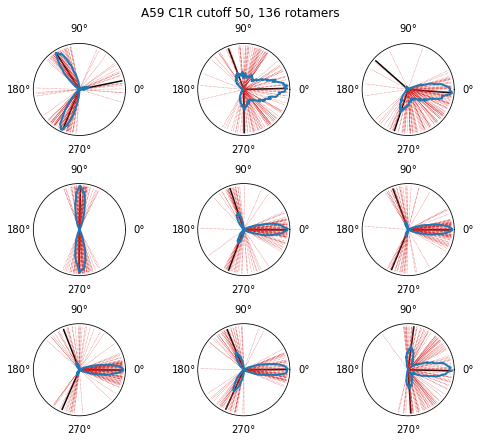

(63,)


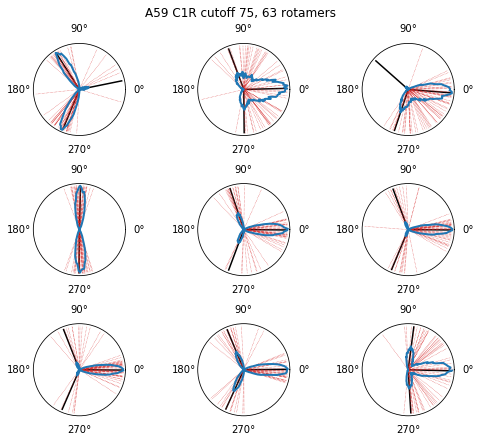

(35,)


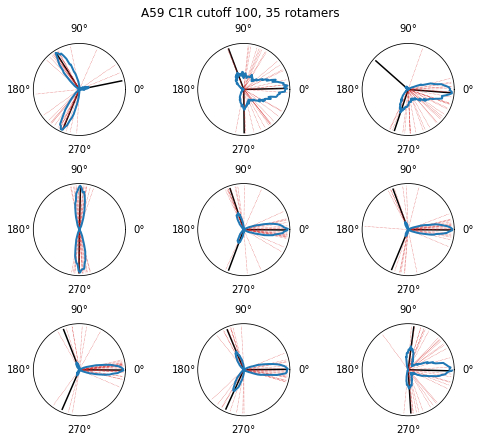

(20,)


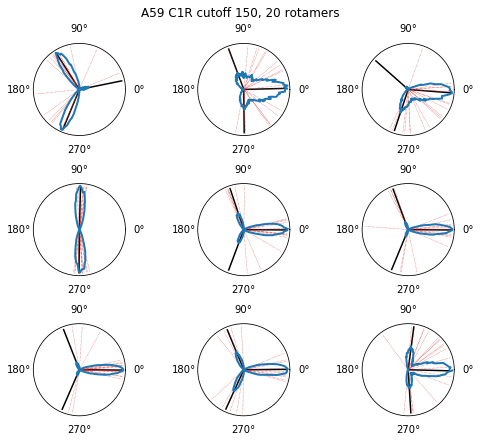

(12,)


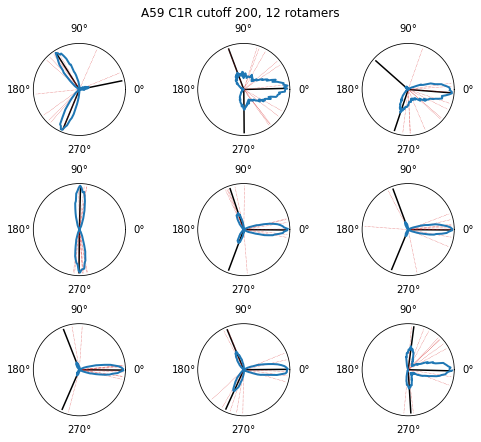

In [256]:
for dye in df.index[:]:
    for cutoff in [50,75,100,150,200]:
        plotClustPolar(df, dye, cutoff)

(143,)


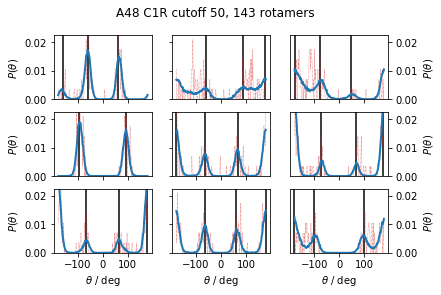

(78,)


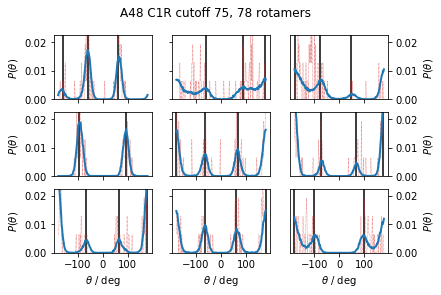

(35,)


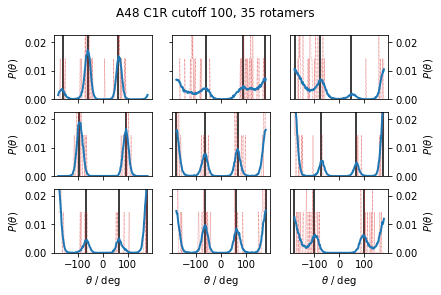

(16,)


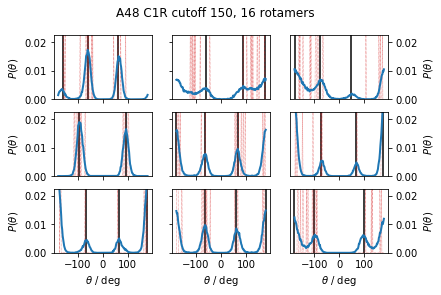

(4,)


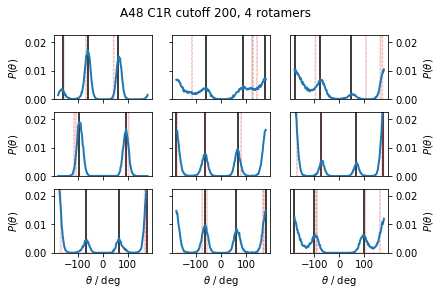

(136,)


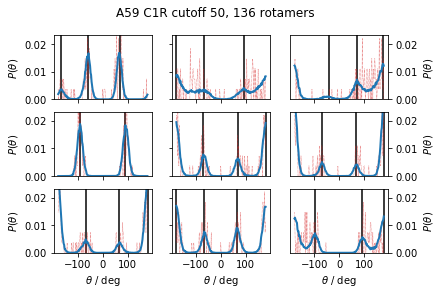

(63,)


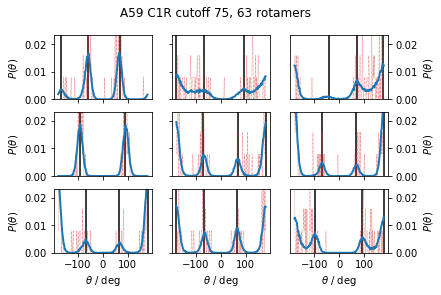

(35,)


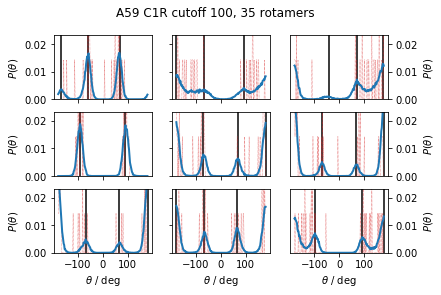

(20,)


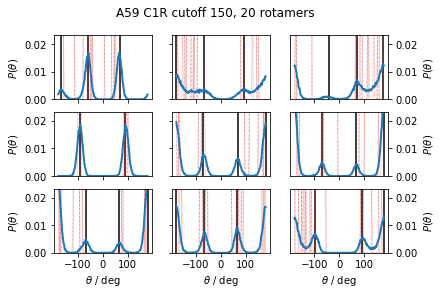

(12,)


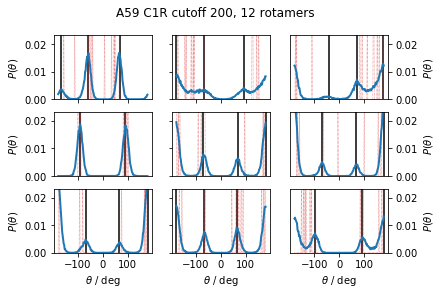

In [257]:
for dye in df.index[:]:
    for cutoff in [50,75,100,150,200]:
        plotClustHist(df, dye, cutoff)

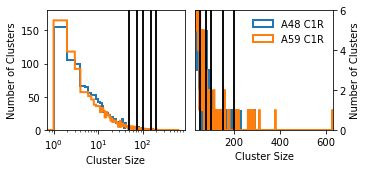

In [330]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(5.2,2.5))
for dye in df.index:
    clusters = pd.read_pickle(path+'/clusters_{:s}_1step.pkl'.format(dye))
    clusters.N.hist(ax=ax1,bins=np.arange(0,clusters.N.max()+1,1),histtype='step',
                    label=dye,lw=2)
    ax1.vlines([50,75,100,150,200],0,200,color='k')
    ax1.set_ylim(0,180)
    ax1.set_xscale('log')
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Number of Clusters')
    ax1.grid(False)
    clusters.N.hist(ax=ax2,bins=np.arange(0,clusters.N.max()+1,1),histtype='step',
                    label=dye.replace('_',' '),lw=2)
    ax2.vlines([50,75,100,150,200],0,165,color='k')
    ax2.set_xlim(30,clusters.N.max())
    ax2.set_ylim(0,6)
    #ax2.set_xscale('log')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Number of Clusters')
    ax2.grid(False)
    
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position("right")
    ax2.legend(handles=handles, labels=labels, frameon=False)

plt.tight_layout(h_pad=1)
plt.savefig(path+'/hist_clusters.pdf')
plt.show()

In [312]:
handles

[None, None]

In [307]:
xy = ax2.get_legend_handles_labels()[0][1].get_xy()
xy

array([[  0.,   0.],
       [  0.,   0.],
       [  1.,   0.],
       ...,
       [630.,   1.],
       [631.,   1.],
       [631.,   0.]])

In [80]:
for dye in ['alexa488','alexa594']: 
    for cutoff in [75,100,150,200]:
        conf = 'c_s{:s}_ff99sbws_vac.pdb'.format(dye[-3:])
        u = MDAnalysis.Universe(prefix+'/'+conf)
        alexa = u.select_atoms('resname S{:s}'.format(dye[-3:]))
        a = np.loadtxt('/Users/giulio/FRETpredict/FRETpredict/lib/rot_lib_matrix_{:s}_{:d}cutoff.txt'.format(dye,cutoff), dtype='float32',
                       usecols=(5))
        print(a.shape[0]/len(alexa),a.sum()/len(alexa))

407.0 100001.0
317.0 100001.0
205.0 100001.0
134.0 100001.0
360.0 100001.0
288.0 100001.0
181.0 100001.0
125.0 100001.0


In [83]:
for dye in ['alexa488','alexa594']: 
    for cutoff in [75,100,150,200]:
        conf = 'c_s{:s}_ff99sbws_vac.pdb'.format(dye[-3:])
        u = MDAnalysis.Universe(prefix+'/'+conf)
        alexa = u.select_atoms('resname S{:s}'.format(dye[-3:]))
        a = np.loadtxt('/Users/giulio/FRETpredict/FRETpredict/lib/rot_lib_matrix_{:s}_3step_{:d}cutoff.txt'.format(dye,cutoff), dtype='float32',
                       usecols=(5))
        print(a.shape[0]/len(alexa),a.sum()/len(alexa))

115.0 100001.0
59.0 100001.0
25.0 100001.0
10.0 100001.0
82.0 100001.0
32.0 100001.0
16.0 100001.0
11.0 100001.0


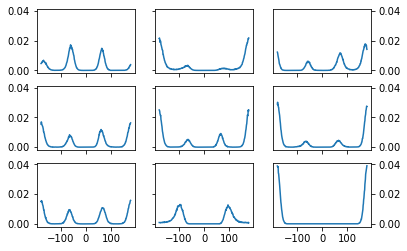

In [147]:
dye = 'alexa488'
traj = 'FRET/c_s{:s}_ff99sbws_remd_npt_s1_nd0_whole.xtc'.format(dye[-3:])
conf = 'FRET/c_s{:s}_ff99sbws_vac.pdb'.format(dye[-3:])

t = md.load_xtc(traj,conf)

dihe = md.compute_dihedrals(t, [[6,8,10,13],[8,10,13,85],[10,13,85,87],[79,76,73,70],
                        [76,73,70,67],[73,70,67,64],[70,67,64,62],[67,64,62,60],[64,62,60,51]], 
                            periodic=True, opt=True)/np.pi*180

fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)

for i,ax in enumerate(axes.flatten()):
    h,b = np.histogram(dihe[:,i],bins=np.arange(-180,180,1),density=True)
    bins = b[:-1]+(b[1]-b[0])/2
    ax.plot(bins,h)

for i in [2,5,8]:
    axes.flatten()[i].yaxis.set_ticks_position('right')
    axes.flatten()[i].yaxis.set_label_position("right")